In [1]:
import torch
import image_encoder as encoder

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


In [ ]:
loader_params = {
    "batch_size": 1,
    "pad_images": True,
    "percent_mask": 0.0,
    "evaluate": True,
    "shuffle": True,
    "place_central": True
}

dataloader = encoder.get_dataloader('dict_traindata.txt', loader_params)
ViT, t_embs = encoder.VisionTransformer.load_model(f"image_encoder/trained_models/vit_11-21-24_400k_vF.pth", print_statements=True, device=device)
ViT = ViT.to(device)

C:\Users\lucas\Desktop\UCSD\291C - Program Synthesis\Project\ARC-AGI\image_encoder\transformers\vision_transformer.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chec

Vision Transformer instantiated with 398,144 parameters using Sinusoidal encodings.


# Visualizing Our Attention

In [3]:
sample_u, sample_attn = None, None
with torch.no_grad():
    ViT.eval()
    for i, (ids, u, _, _, _, _) in enumerate(dataloader):
        B, H, W = u.shape
        u = u.to(device)

        # Forward pass
        cls_logits, patch_logits, attn = ViT(u, save_attn=True, temperature=1)

        sample_attn = attn[0][0, 1].cpu()
        sample_u = u[0].cpu()
        break

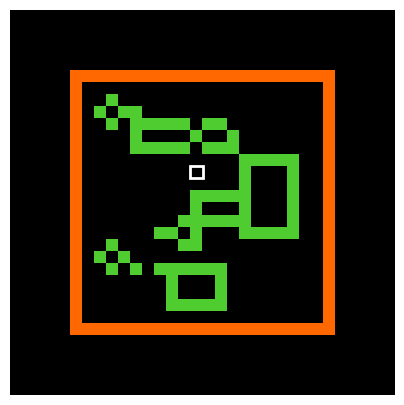

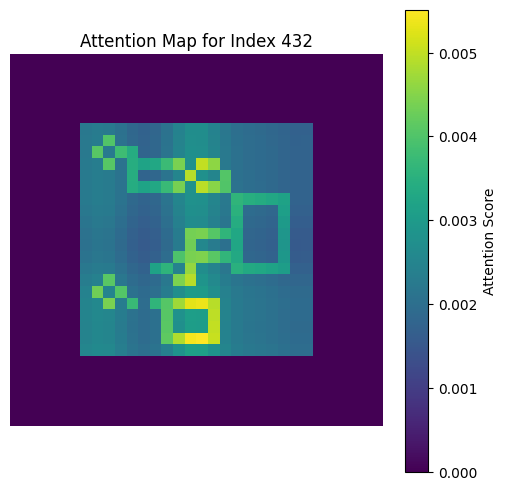

In [4]:
idx = encoder.get_idx(x=15, y=13, CLS=False, size=sample_u.shape)
encoder.plot_tensor_with_highlight(sample_u, idx)
encoder.plot_attention_map(sample_attn, idx, size=sample_u.shape)

# Cosine Sim on CLS Token

In [5]:
# This will take some time -- it is generating CLS token embeddings for all images in the dataset
ids_list = []
images_tensor = []
cls_tensor = []

with torch.no_grad():
    ViT.eval()
    for i, (ids, u, _, _, _, _) in enumerate(dataloader):
        B, H, W = u.shape
        u = u.to(device)

        cls_logits, _, _ = ViT(u, save_attn=False, temperature=1)

        ids_list.extend(ids)
        images_tensor.append(u.cpu())
        cls_tensor.append(cls_logits[:, 0].cpu())
        if i > 100:
            break
        
    images_tensor = torch.cat(images_tensor, dim=0)
    cls_tensor = torch.cat(cls_tensor, dim=0)

In [6]:
def get_delta_vec(t_embs, transformation):
    with torch.no_grad():
        vec = t_embs.get_embedding(transformation)
        return vec.cpu()

Reference Image


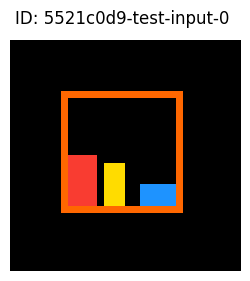

Transformation vectors applied: {'translation': 0, 'shuffle_colors': 0, 'rotate': 0, 'vertical_mirror': 1, 'horizontal_mirror': 0, 'resize': 0}




Closest 5 images:


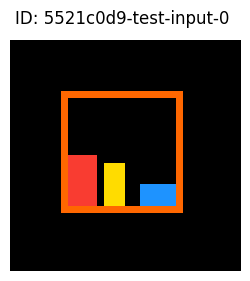

Similarity = 0.800



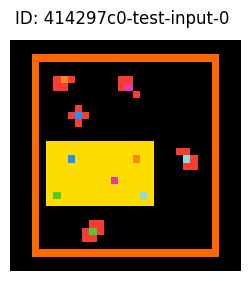

Similarity = 0.748



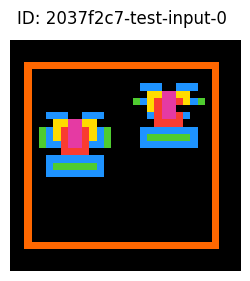

Similarity = 0.724



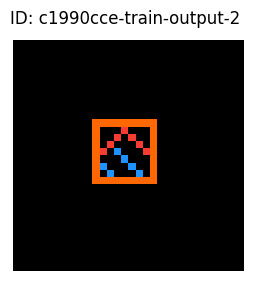

Similarity = 0.711



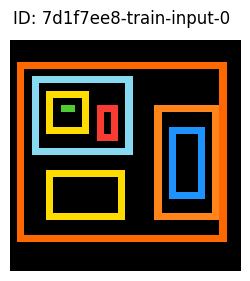

Similarity = 0.695




Furthest 5 images:


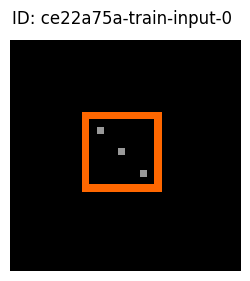

Similarity = -0.578



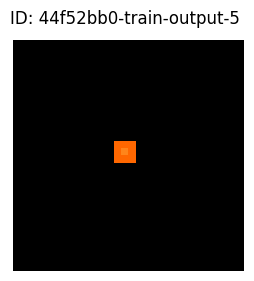

Similarity = -0.571



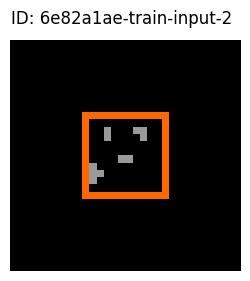

Similarity = -0.528



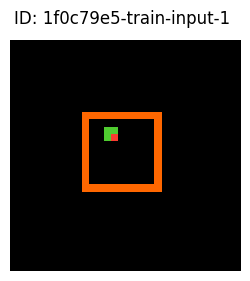

Similarity = -0.521



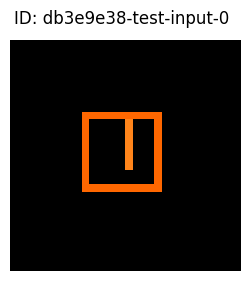

Similarity = -0.520



In [7]:
# Compute cosine similarity for given id
# id  = 'd4a91cb9-train-output-1'
# idx = ids_list.index(id)
idx = 2

transformation = {
    'translation': 0,
    'shuffle_colors': 0,
    'rotate': 0,
    'vertical_mirror': 1,
    'horizontal_mirror': 0,
    'resize': 0
}

vec = get_delta_vec(t_embs, transformation)


print(f"Reference Image")
encoder.plot_tensors_with_colors(images_tensor[idx:idx+1], f"ID: {ids_list[idx]}")
print(f"Transformation vectors applied: {transformation}")
print(f"{'='*60}\n")

# Compute our closest and furthest embeddings
k = 5
closest_embeddings, closest_sims = encoder.top_k_cosine_similarity(cls_tensor, idx, k, vec, largest=True)
furthest_embeddings, furthest_sims = encoder.top_k_cosine_similarity(cls_tensor, idx, k, vec, largest=False)


print(f"\n\n\nClosest {k} images:")
for i, closest_idx in enumerate(closest_embeddings):
    closest_id = ids_list[closest_idx]
    encoder.plot_tensors_with_colors(images_tensor[closest_idx:closest_idx+1], f"ID: {closest_id}")
    print(f"Similarity = {closest_sims[i]:.3f}\n")

print(f"\n\n\nFurthest {k} images:")
for i, furthest_idx in enumerate(furthest_embeddings):
    furthest_id = ids_list[furthest_idx]
    encoder.plot_tensors_with_colors(images_tensor[furthest_idx:furthest_idx+1], f"ID: {furthest_id}")
    print(f"Similarity = {furthest_sims[i]:.3f}\n")